In [150]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [151]:
df = pd.read_csv('combinedData.csv')

Encoding

In [152]:
id_features = ['tmID','playerID', 'college', 'collegeOther', 'coachID']
categorical_features = [ 'pos', 'award', 'confID', 'results']
df = pd.get_dummies(df, columns=categorical_features)


In [153]:
for feature in id_features:
    label_encoder = LabelEncoder()
    df[f'{feature}_encoded'] = label_encoder.fit_transform(df[feature])

df['playoff'] = df['playoff'].replace({'N': 0, 'Y': 1})

df = df.drop(columns=id_features)

In [154]:
#YYYY-MM-DD to unix
df['birthDataUnix'] = pd.to_datetime(df['birthDate']).apply(lambda x: int(x.timestamp()))
df = df.drop(columns=['birthDate'])

df_original=df
feature_cols = [col for col in df.columns if col not in ['playoff']]

# Data Leakage

features not to replace with last years:
 - tmID
 - year
 - playerID
 - stint
 - pos
 - height
 - weight
 - college
 - college other
 - birthDate
 - age
 - coachId
 - coachStint
 - confID

In [155]:
features_to_replace = [col for col in feature_cols if col not in [
    'tmID', 'year', 'playerID', 'stint', 'pos', 'height', 'weight', 'college',
    'collegeOther', 'birthDate', 'age', 'coachID', 'coachStint', 'confID',
    'tmID_encoded', 'playerID_encoded', 'college_encoded','collegeOther_encoded',
    'coachID_encoded','birthDataUnix','confID_EA','confID_WE','pos_C','pos_C-F',
    'pos_F','pos_F-C','pos_F-G','pos_G','pos_G-F']]

print(features_to_replace)

['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'mpg', 'ppg', 'apg', 'rpg', 'spg', 'bpg', 'topg', 'pfpg', 'fg%', '3p%', 'ft%', 'orpg', 'drpg', 'pointsFromFieldGoal', 'percentage_pointsFromFieldGoal', 'percentage_pointsFromFreeThrow', 'percentage_pointsFromThree', 'coachWon', 'coachLost', 'coach W/L Ratio', 'seed', 'o_fga', 'o_fta', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'win_ratio', 'homeW_ratio', 'awayW_ratio', 'min', 'o_fg%', 'o_ft%', 'o_3p%', 'd_fg%', 'd_ft%', 'd_3p%', 'coachAward', 'award_ASGMVP', 'award_DPOTY', 'award_KPSA', 'award_MIP', 'award_MVP', 'award_ROTY', 'award_SWOTY', 'award_WADT', 'award_WADTHM', 'award_WFMVP', 'results_Unknow

# Decision Tree

In [156]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = DecisionTreeClassifier()

for i in range(2, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)


    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


/tmp/ipykernel_14346/2713911105.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/2713911105.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/2713911105.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/2713911105.py:35: SettingWithCopyWarning: 
A value is t

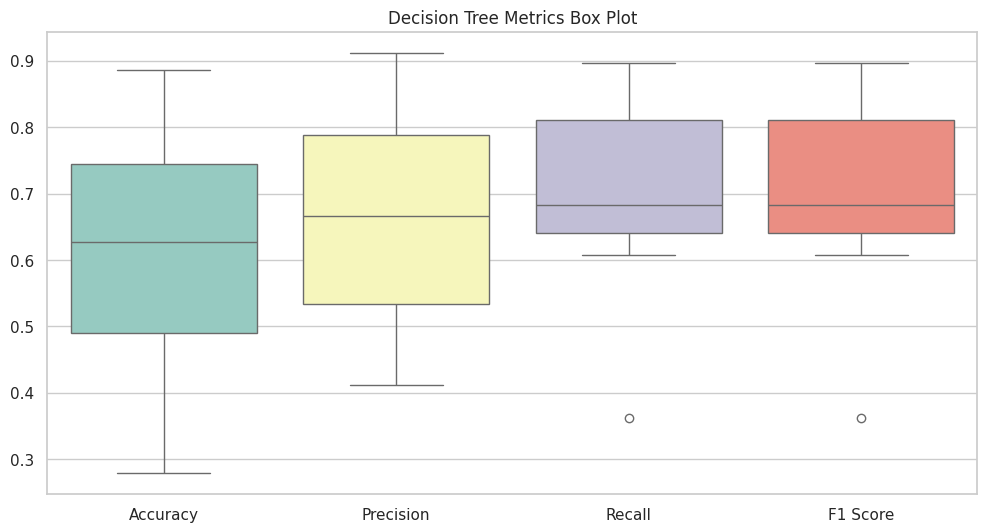

In [157]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Decision Tree Metrics Box Plot")

plt.show()


In [158]:
accuracy_average = round(sum(accuracies)/9, 3)
precision_average = round(sum(precisions)/9, 3)
recall_average = round(sum(recalls)/9, 3)
f1s_average = round(sum(f1s)/9, 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 63.1%
Precision Average: 67.7%
Recall Average: 69.3%
F1 Average: 69.3%


In [159]:
dot_data = export_graphviz(model, out_file=None,
                          feature_names=X_train.columns, # Specify your feature names
                          class_names=['No Playoff', 'Playoff'], # Specify your class names
                          filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree") # This will save the tree as 'decision_tree.pdf'
graph.view("decision_tree")   # This will open the tree in your default PDF viewer


'decision_tree.pdf'

# Random Forest

In [160]:
label_encoder = LabelEncoder()
accuracies = []
precisions = []
recalls = []
f1s = []
model = RandomForestClassifier()

for i in range(2, 11):
    train_years = range(1,i)
    test_year = i

    train_data = df[df['year'].isin(train_years)]
    #print("============================================================================")
    #print(train_data)
    replace_data = df[df['year'] == test_year-1]
    test_data = df[df['year'] == test_year]
    #print(test_data)
    #print("============================================================================")

    # replace data with last years data
    key_columns = ['tmID_encoded', 'playerID_encoded']
    
    for index, current_row in test_data.iterrows():
        common_key = tuple(current_row[key_columns])

        # Check if there's a matching entry in the previous year's dataframe
        matching_entry = replace_data[(replace_data[key_columns[0]] == current_row[key_columns[0]]) & (replace_data[key_columns[1]] == current_row[key_columns[1]])]

        if not matching_entry.empty:
            # Replace values in columns_to_replace with data from the matching entry
            for column in features_to_replace:
                test_data.at[index, column] = matching_entry.iloc[0][column]
        else:
            # Remove the row if there is no matching entry
            test_data.drop(index, inplace=True)
    
    #print(test_data)

    y_train = train_data['playoff']
    y_test = test_data['playoff']

    # Prepare the data for training and testing using unaggregated feature data (X)
    X_train, X_test = train_data[feature_cols], test_data[feature_cols]

    # Train your model (e.g., Random Forest)
    model.fit(X_train, y_train)

    # Make predictions for individual players
    player_predictions = model.predict(X_test)


    # Evaluate the model using the encoded labels
    accuracy = accuracy_score(y_test, player_predictions)
    precision = precision_score(y_test, player_predictions)
    recall = recall_score(y_test, player_predictions)
    f1 = recall_score(y_test, player_predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)


/tmp/ipykernel_14346/4005464225.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/4005464225.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/4005464225.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(index, inplace=True)
/tmp/ipykernel_14346/4005464225.py:35: SettingWithCopyWarning: 
A value is t

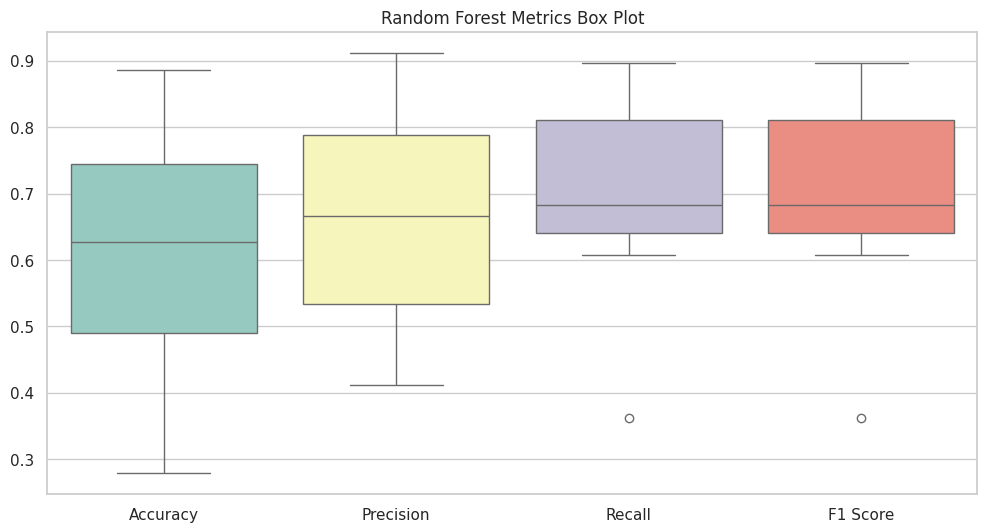

In [161]:
data = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1s})
# Create a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)  # Create a single subplot for the box plot
sns.boxplot(data=data, palette="Set3")
plt.title("Random Forest Metrics Box Plot")

plt.show()

In [162]:
accuracy_average = round(sum(accuracies)/9, 3)
precision_average = round(sum(precisions)/9, 3)
recall_average = round(sum(recalls)/9, 3)
f1s_average = round(sum(f1s)/9, 3)

print(f"Accuracy Average: {accuracy_average*100}%")
print(f"Precision Average: {precision_average*100}%")
print(f"Recall Average: {recall_average*100}%")
print(f"F1 Average: {f1s_average*100}%")

Accuracy Average: 63.1%
Precision Average: 67.7%
Recall Average: 69.3%
F1 Average: 69.3%
